In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
import datetime as dt
from sklearn.cluster import KMeans

# Loading Dataset

In [2]:
df = pd.read_csv('OnlineRetail.csv',  sep = ',',encoding = "ISO-8859-1", header= 0)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Data Wrangling

In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [6]:
df.isnull().sum()

InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64


In [9]:
df['CustomerID'] = df.CustomerID.fillna('Unknown') 

In [11]:
## remove null
## remove negative value in Quantity and UnitPrice column
df_new = df.dropna() 
df_new = df_new[df_new.Quantity > 0] 
df_new = df_new[df_new.UnitPrice > 0] 

In [14]:
df_new.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [15]:
df_new['Revenue'] = df_new['Quantity'] * df_new['UnitPrice'] 

# RFM Analysis

In [19]:
rfm = df_new.groupby(['CustomerID'],as_index=False)\
        .agg({'InvoiceDate': lambda x : (dt.datetime.now() - x.max()).days, 
              'InvoiceNo': lambda x : len(x), 
              'Revenue': lambda x: x.sum()})
rfm['InvoiceDate'] = rfm['InvoiceDate'].astype(int)
rfm.rename(columns={'InvoiceDate': 'Recency', 
                    'InvoiceNo': 'Frequency', 
                    'Revenue': 'Monetary'}, inplace=True)

In [21]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,4243,1,77183.60
1,12347.0,3957,182,4310.00
2,12348.0,3993,31,1797.24
3,12349.0,3936,73,1757.55
4,12350.0,4227,17,334.40


In [23]:
quantiles = rfm.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
segmented_rfm = rfm
segmented_rfm

,CustomerID,Recency,Frequency,Monetary
0,12346.0,4243,1,77183.60
1,12347.0,3957,182,4310.00
2,12348.0,3993,31,1797.24
3,12349.0,3936,73,1757.55
4,12350.0,4227,17,334.40
...,...,...,...,...
4334,18281.0,3921,7,80.82
4335,18282.0,4133,12,178.05
4336,18283.0,3927,756,2094.88
4337,18287.0,3917,70,1837.28


In [24]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [25]:
segmented_rfm['r_quartile'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['Monetary'].apply(FMScore, args=('Monetary',quantiles,))
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile
0,12346.0,4243,1,77183.60,1,1,4
1,12347.0,3957,182,4310.00,3,4,4
2,12348.0,3993,31,1797.24,2,2,4
3,12349.0,3936,73,1757.55,4,3,4
4,12350.0,4227,17,334.40,1,1,2


In [26]:
segmented_rfm['RFM_Segement'] = segmented_rfm.r_quartile.map(str)+segmented_rfm.f_quartile.map(str)+segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Segement
0,12346.0,4243,1,77183.60,1,1,4,114
1,12347.0,3957,182,4310.00,3,4,4,344
2,12348.0,3993,31,1797.24,2,2,4,224
3,12349.0,3936,73,1757.55,4,3,4,434
4,12350.0,4227,17,334.40,1,1,2,112


In [27]:
segmented_rfm['RFM_Score'] = segmented_rfm.r_quartile + segmented_rfm.f_quartile + segmented_rfm.m_quartile
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Segement,RFM_Score
0,12346.0,4243,1,77183.60,1,1,4,114,6
1,12347.0,3957,182,4310.00,3,4,4,344,11
2,12348.0,3993,31,1797.24,2,2,4,224,8
3,12349.0,3936,73,1757.55,4,3,4,434,11
4,12350.0,4227,17,334.40,1,1,2,112,4


# Preprocessing data for Clustering

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

<AxesSubplot:xlabel='Monetary', ylabel='Density'>

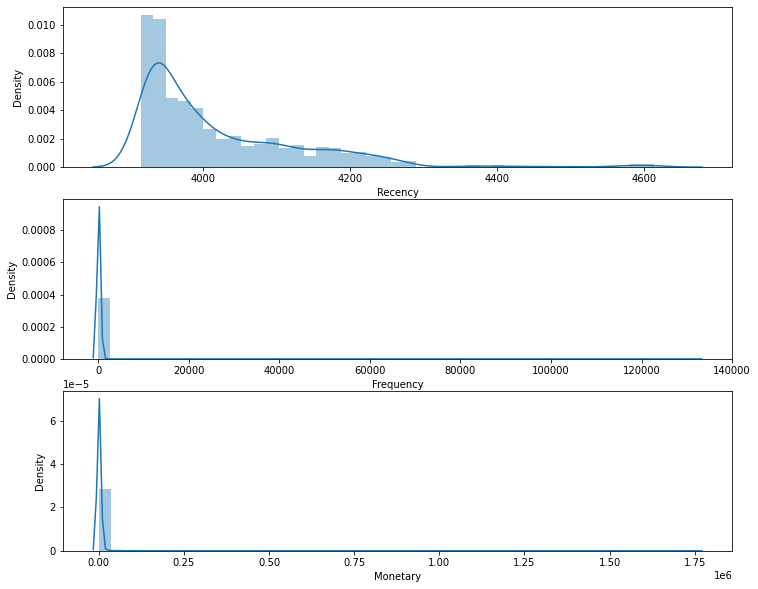

In [29]:
# Checking the distribution of Recency, Frequency and MonetaryValue variables.
plt.figure(figsize=(12,10))

plt.subplot(3, 1, 1)
sns.distplot(segmented_rfm['Recency'])

plt.subplot(3, 1, 2)
sns.distplot(segmented_rfm['Frequency'])

plt.subplot(3, 1, 3)
sns.distplot(segmented_rfm['Monetary'])

In [30]:
# Checking for constant mean and variance

segmented_rfm[['Recency','Frequency','Monetary']].describe()

,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4.339000e+03
mean,4022.238534,122.171929,2.458328e+03
std,115.082122,2018.863821,2.809265e+04
min,3916.000000,1.000000,3.750000e+00
25%,3939.000000,17.000000,3.074300e+02
50%,3977.000000,41.000000,6.745200e+02
75%,4078.000000,100.000000,1.662060e+03
max,4614.000000,132220.000000,1.755277e+06


In [31]:
segmented_rfm.dtypes

CustomerID       object
Recency           int64
Frequency         int64
Monetary        float64
r_quartile        int64
f_quartile        int64
m_quartile        int64
RFM_Segement     object
RFM_Score         int64
dtype: object

In [33]:
data = segmented_rfm[segmented_rfm['Recency'] > 0]
data.reset_index(drop=True,inplace=True)
data.head()

,CustomerID,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Segement,RFM_Score
0,12346.0,4243,1,77183.60,1,1,4,114,6
1,12347.0,3957,182,4310.00,3,4,4,344,11
2,12348.0,3993,31,1797.24,2,2,4,224,8
3,12349.0,3936,73,1757.55,4,3,4,434,11
4,12350.0,4227,17,334.40,1,1,2,112,4


In [34]:
# Unskew the data

raw_data = data[['Recency','Frequency','Monetary']]
data_log = np.log(raw_data)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(data_log)

data_normalized = scaler.transform(data_log)

data_norm = pd.DataFrame(data=data_log, index=raw_data.index, columns=raw_data.columns)


In [35]:
data_norm.head()

,Recency,Frequency,Monetary
0,8.353026,0.000000,11.253942
1,8.283241,5.204007,8.368693
2,8.292298,3.433987,7.494007
3,8.277920,4.290459,7.471676
4,8.349248,2.833213,5.812338


/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

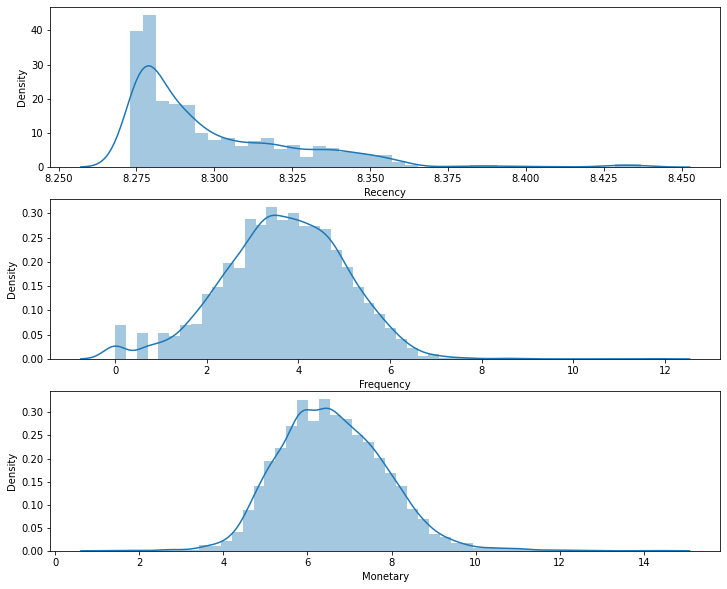

In [36]:
plt.figure(figsize=(12,10))

plt.subplot(3, 1, 1)
sns.distplot(data_norm['Recency'])

plt.subplot(3, 1, 2)
sns.distplot(data_norm['Frequency'])

plt.subplot(3, 1, 3)
sns.distplot(data_norm['Monetary'])

plt.show()

In [38]:
sse = {}

for k in range(1, 21):
  
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(data_norm)
    sse[k] = kmeans.inertia_
    

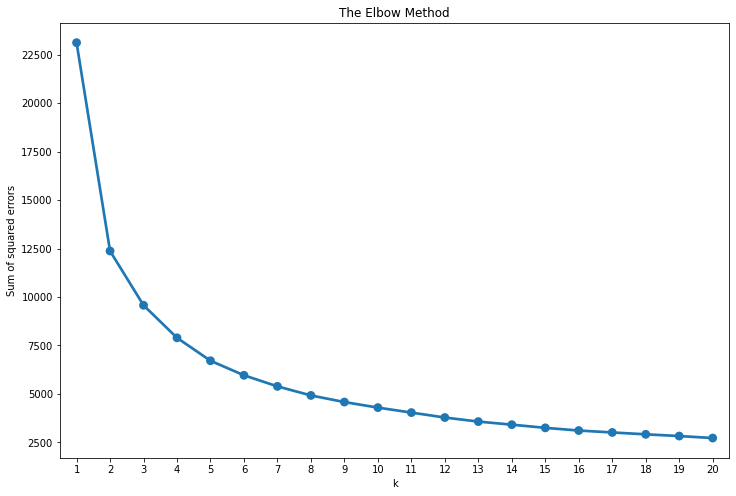

In [36]:
plt.figure(figsize=(12,8))

plt.title('The Elbow Method')
plt.xlabel('k'); 
plt.ylabel('Sum of squared errors')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [39]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(data_norm)
cluster_labels = kmeans.labels_

In [46]:
# Create a cluster label column in the original DataFrame
data_norm_k3 = data_norm.assign(Cluster = cluster_labels)
data_k3 = raw_data.assign(Cluster = cluster_labels)

# Calculate average RFM values and size for each cluster
summary_k3 = data_k3.groupby(['Cluster']).agg({'Recency': 'mean',
                                               'Frequency': 'mean',
                                               'Monetary': ['mean', 'count'],}).round(2)

In [42]:
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(data_norm)
cluster_labels = kmeans.labels_

In [45]:
# Create a cluster label column in the original DataFrame
data_norm_k4 = data_norm.assign(Cluster = cluster_labels)
data_k4 = raw_data.assign(Cluster = cluster_labels)

# Calculate average RFM values and size for each cluster
summary_k4 = data_k4.groupby(['Cluster']).agg({'Recency': 'mean',
                                               'Frequency': 'mean',
                                               'Monetary': ['mean', 'count'],}).round(2)

In [44]:
display(summary_k3)
display(summary_k4)

Recency Frequency Monetary      
            mean      mean     mean count
Cluster                                  
0        4084.97     11.25   262.47  1258
1        3958.37    358.33  7566.33  1165
2        4019.89     51.41   794.22  1916

Recency Frequency  Monetary      
            mean      mean      mean count
Cluster                                   
0        4054.49     28.58    464.15  1533
1        3985.76     87.15   1508.57  1391
2        4091.90      6.92    217.17   734
3        3949.08    528.60  11302.97   681

In [49]:
cluster_avg = data_k4.groupby(['Cluster']).mean()
population_avg = raw_data.head().mean()

In [50]:
cluster_avg

,Recency,Frequency,Monetary
Cluster,,,
0,4054.487932,28.583823,464.145892
1,3985.757009,87.154565,1508.574832
2,4091.899183,6.918256,217.167071
3,3949.076358,528.597651,11302.967211


In [51]:
population_avg

Recency       4071.200
Frequency       60.800
Monetary     17076.558
dtype: float64

In [52]:
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)

,Recency,Frequency,Monetary
Cluster,,,
0,-0.00,-0.53,-0.97
1,-0.02,0.43,-0.91
2,0.01,-0.89,-0.99
3,-0.03,7.69,-0.34


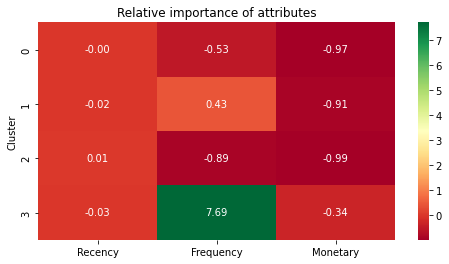

In [53]:
# Plot heatmap
plt.figure(figsize=(8, 4))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()